# Multi-Output Networks and Batch Processing


The goal of this exercise is to get to know some regularization techniques when implementing deep learning methods.
For this purpose, we select a dataset that contains data in different formats, some binary ($x_d \in \{-1,1\}$) and some numerical ($x_d\in \mathbb N$); and some are categorical, which we ignore for now.
As target values, this dataset contains three numerical outputs, so, $\vec t \in \mathbb R^3$ for each sample.
These target values should be approximated with a two-layer multi-output network that we will train with the $\mathcal J^{L_2}$ loss.



Remember to make use of `numpy` in the matrix calculation, e.g. `numpy.dot`, `numpy.exp`, `numpy.mean` 


## Dataset

The dataset of our choice is the Student Performance estimation dataset that was collected in Portugal in two different schools and with two different subjects, i.e., math and Portuguese (the mother tongue).
The dataset contains many different inputs such as a binary representation of the school, gender, family sizes, and alike, as well as numerical representations of age, travel time, and alcohol consumption.
The dataset also includes some categorical data, which we skip in this assignment.
See https://archive.ics.uci.edu/ml/datasets/Student+Performance for more information on the dataset.
As a start, we will rely on the Portuguese performance (`"por"`), but you can also try to use the Math samples (`"mat"`).

### Task 1: Dataset Loading


Load the dataset from files and provide the input matrix $\mathbf X \in \mathbb R^{(D+1)\times N}$ and the output matrix $\mathbf T \in \mathbb R^{O\times N}$.

Due to the difficulty of the task, most of the implementation is provided.
The implementation is very literal and, therefore, hopefully readable, while maybe not the most efficient.

We skip categorical inputs (indexes 8-11) for now.
All other entries are converted either into binary $(-1,1)$ or into an integer range $(0,1,\ldots)$.
The three outputs range between 0 and 20 each. The bias value for $x_0=1$ is also already included.
You just need to make sure that the data $(X,T)$ is returned in the desired format.

In [33]:
import numpy as np
import copy

from tqdm.notebook import tqdm

In [34]:
import math
import numpy
import os

# Dataset origin: https://archive.ics.uci.edu/ml/datasets/Student+Performance

def dataset(course="por"):
  # load dataset and provide input and target data
  # possible data files are "mat" and "por"

  # download data file from URL
  dataset_zip_file = "data/student.zip"
  if not os.path.exists(dataset_zip_file):
    import urllib.request
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", dataset_zip_file)
    print ("Downloaded datafile", dataset_zip_file)

  import zipfile
  import csv
  import io

  # collect inputs
  inputs = []
  targets = []
  # some default values: yes=1, no=-1
  yn = {"yes":1.,"no":-1.}
  # read through dataset (without actually unzippiung to a file):
  # ... open zip file
  zip = zipfile.ZipFile(dataset_zip_file)
  # ... open data file inside of zip file and convert bytes to text
  datafile = io.TextIOWrapper(zip.open(os.path.join(F"student-{course}.csv"), 'r'))
  # ... read through the lines via CSV reader, using the correct delimited
  reader = csv.reader(datafile, delimiter=";")
  # ... skip header line
  next(reader)
  for splits in reader:
    # read input values
    inputs.append([
      1.,                             #### BIAS ####
      {"GP":1.,"MS":-1.}[splits[0]],  # school
      {"M":1.,"F":-1.}[splits[1]],    # gender
      float(splits[2]),               # age
      {"U":1.,"R":-1.}[splits[3]],    # address
      {"LE3":1.,"GT3":-1.}[splits[4]],# family size
      {"T":1.,"A":-1.}[splits[5]],    # parents living together
      float(splits[6]),               # mother education
      float(splits[7]),               # father education
      # skip categorical values
      float(splits[12]),              # travel time
      float(splits[13]),              # study time
      float(splits[14]),              # failures
      yn[splits[15]],                 # extra support
      yn[splits[16]],                 # family support
      yn[splits[17]],                 # paid support
      yn[splits[18]],                 # activities
      yn[splits[19]],                 # nursery school
      yn[splits[20]],                 # higher education
      yn[splits[21]],                 # internet
      yn[splits[22]],                 # romantic
      float(splits[23]),              # family relation
      float(splits[24]),              # free time
      float(splits[25]),              # going out
      float(splits[26]),              # workday alcohol
      float(splits[27]),              # weekend alcohol
      float(splits[28]),              # health
      float(splits[29]),              # absences
    ])

    # read targets values
    targets.append([
      float(splits[30]),              # grade for primary school
      float(splits[31]),              # grade for secondary school
      float(splits[32]),              # grade for tertiary school
    ])

  print(F"Loaded dataset with {len(targets)} samples")
  return numpy.array(inputs).T, numpy.array(targets).T / 20.0

### Test 1: Assert Valid Outputs

This test will check the dimension of the loaded dataset, i.e. $\mathbf X\in \mathbb R^{(D+1)\times N}$ and $\mathbf T \in \mathbb R^{O\times N}$, and also assure that all target data is in the range $t\in[0,20]$.

Please make sure that your implementation can pass these tests before moving to the next task

In [35]:
X, T = dataset("por")

assert numpy.all(T >= 0) and numpy.all(T <= 20)

assert X.shape[0] == 27
assert T.shape[0] == 3
assert T.shape[1] == X.shape[1]

Loaded dataset with 649 samples


### Task 2: Input Data Standardization

Since the data is in different input regimes, we want to standardize the data.
For this purpose, we need to compute the mean and the standard deviation of the data for each input dimension.
Then, we implement a function to perform the standardization of the data using the previously computed mean and standard deviation. Make sure that you handle the bias neuron $x_0$ correctly.

Please note that `numpy` has all the functionality that you need.

In [36]:
# compute mean and standard deviation over dataset
mean = numpy.mean(X[1:, :], axis=1)
std = numpy.std(X[1:, :], axis=1)
# assure to handle x_0 correctly
mean = numpy.concatenate(([0], mean))
std = numpy.concatenate(([1], std))

pre_X = copy.deepcopy(X)

def standardize(x, mean, std):
  # standardize the given data with the given mean and standard deviation
  return (x - mean[:,None]) / std[:,None]

# standardize our dataset
X = standardize(X, mean, std)

### Task 3: Batch Processing

In order to run stochastic gradient descent, we need to split our dataset into batches of a certain batch size $B$. Implement a function that turns the dataset $(X,T)$ into batches of a certain batch size $B$.
Implement this function as a generator function, i.e., use ``yield`` instead of ``return``.
Circulate the dataset afresh when all data is consumed, and shuffle the data in each epoch.
Make sure that you yield both the input batch and the target batch.

In [37]:
def batch_v0(X, T, batch_size=16):
    # get number of samples
    n_samples = X.shape[1]
    #number of batches in total
    n_batches = math.ceil(n_samples/batch_size)
    
    while True:
        # shuffle
        indices = np.random.permutation(n_samples)
        
        # c is current batch
        for c, i in enumerate(range(0,n_samples, batch_size)):
            j = indices[i:i+batch_size]
            X_batch = X[:,j]
            T_batch = T[:,j]

            # yield mini-batch inputs, targets, boolean checking if last batch
            yield X_batch, T_batch, c == n_batches-1

In [38]:
def batch(X, T, batch_size=16):
    # get number of samples
    n_samples = X.shape[1]
    #number of batches in total
    n_batches = math.ceil(n_samples/batch_size)
    divisible = True
    
    if n_samples % batch_size!= 0:
        k = n_samples % batch_size
        rest = batch_size - k 
        divisible = False

    while True:
        # shuffle
        indices = np.random.permutation(n_samples)
        
        # c is current batch
        for c, i in enumerate(range(0,n_samples, batch_size)):
            j = indices[i:i+batch_size]
            X_batch = X[:,j]
            T_batch = T[:,j]

            if not(divisible) and c == n_batches-1:
                X_batch = numpy.append(X_batch, X[:,indices[0:rest]],axis=1)
                T_batch = numpy.append(T_batch, T[:,indices[0:rest]], axis=1)

            # yield mini-batch inputs, targets, boolean checking if last batch
            yield X_batch, T_batch, c == n_batches-1

### Test 2: Test your Batches

This test is to assure that your batch generation function works as expected. 
We define some test data for this purpose.
The code below checks whether your batch function returns batches with correct content, i.e., $(\vec x, \vec t)$-alignment. 
It also checks that the batches are in the correct dimensions, i.e., that $\mathbf X \in \mathbb R^{(D+1)\times B}$ and $\mathbf T \in \mathbb R^{O\times B}$.

Make sure you can pass this test before moving forward.

In [39]:
XX = numpy.array([[i] * 5 for i in range(50)]).T
TT = numpy.array([[i] for i in range(10,60)]).T

batch_size = 16
remainder = np.remainder(XX.shape[1], batch_size)
remainder = batch_size if remainder == 0 else remainder
print(f"The last batch should have size: {remainder}")

for counter, (x,t,last_batch) in enumerate(batch_v0(XX, TT, batch_size)):
    # Test 2 was modified to:
    # if last batch then the last batch should have size:
    # Remainder of Dataset_size / batch_size
    # e.g., remainder of 50/16 is 2
    # so last batch should have size of 2
    current_batch_size = remainder if last_batch else batch_size
    
    assert x.shape[0] == 5
    assert t.shape[0] == 1
    assert x.shape[1] == current_batch_size
    assert t.shape[1] == current_batch_size
    assert numpy.all(x == t-10)

    if counter == 20: 
        print('Test passed!')
        break


The last batch should have size: 2
Test passed!


In [40]:
XX = numpy.array([[i] * 5 for i in range(50)]).T
TT = numpy.array([[i] for i in range(10,60)]).T

for counter, (x,t,batch_size) in enumerate(batch(XX, TT, 16)):
  assert x.shape[0] == 5
  assert x.shape[1] == 16
  assert t.shape[0] == 1
  assert t.shape[1] == 16
  assert numpy.all(x == t-10)
  if counter == 20: 
    print('Test passed!')
    break

Test passed!


## Gradient Descent

To train a two-layer multi-output regression network, we need to implement some functions.
The network output is computed in three steps:

  * Compute network activation for a batch of inputs $\mathbf X$: $\mathbf A = \mathbf W^{(1)}\mathbf X$
  * Call the activation function element-wise: $\mathbf H = g(\mathbf A)$. Here, we rely on the logistic activation function $\sigma$. Assure that the hidden neuron bias $\mathbf H_{0,:}$ is set appropriately.
  * Compute the output $\mathbf Y$ of the batch: $\mathbf Y = \mathbf W^{(2)}\mathbf H$.

### Task 4: Multi-Output Network

Implement a multi-target network that computes the output matrix $\mathbf Y$ for a given input dataset/batch $\mathbf X$ and given parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using `numpy` operations. 
The function should return both the output $\mathbf Y$ and the output of the hidden units $\mathbf H$ since we will need these in gradient descent. Select the logistic function $\sigma$ as the activation function.

In [41]:
def network(X, Theta):
    W1, W2 = Theta

    # compute activation
    A = np.matmul(W1, X)

    # compute hidden unit output
    H = 1 / (1 + np.exp(-A))
    H = np.vstack((np.ones((1, H.shape[1])), H))

    # compute network output
    Y = np.matmul(W2, H)

    return Y, H

### Task 5: Loss Implementation

Implement a loss function that returns the squared loss $\mathcal J^{L_2} = \frac1B \|\mathbf Y - \mathbf T\|_F^2$ for given network outputs $\mathbf Y$ and target values $\mathbf T$.
Use `numpy` or `scipy` functionality for this task.

In [42]:
def loss(Y, T):

    J = 1/Y.shape[1]*np.square(np.linalg.norm(Y-T, axis=0))
    return J

### Task 6: Gradient Implementation

Implement a function that computes and returns the gradient for a given batch $(\mathbf X, \mathbf T)$, the given network outputs $\mathbf Y$ and $\mathbf H$ as well as current parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$.
Make sure to compute the gradient with respect to both weight matrices. Remember that we have used $\sigma$ as the activation function.
Implement the function using the fast version provided in the lecture and make use of `numpy` operations.

In [43]:
def sigmoid_derivative(inp):
    
    return np.multiply(inp, 1 - inp)

In [44]:
def gradient(X, T, Y, H, Theta):
    
    W1, W2 = Theta

    # Backpropagation: output layer -> hidden layer
    delta2 = Y-T
    # second layer gradient
    g2 = np.dot(2/X.shape[1], np.matmul(delta2, H.T))
    
    # Backpropagation: hidden layer -> input layer
    delta1 = np.multiply(sigmoid_derivative(H), np.matmul(W2.T, delta2))
    # first layer gradient    
    g1 = np.dot(2/X.shape[1], np.matmul(delta1, X.T))

    return g1, g2

### Task 7: Iterative Gradient Descent


Implement gradient descent for a given number of 10'000 epochs (**not batches!**) using given initial parameters $\Theta$ and a given batch size $B$, as well as a learning rate of $\eta=0.001$.

Make use of the standardized dataset from Task 2, split into batches with the function from Task 3, the network from Task 4, the loss from Task 5, and the gradient from Task 6.

Make sure that the network output $\mathbf Y$ and the hidden unit output $\mathbf H$ are computed only once for each batch. After applying gradient descent, add an option to use momentum learning with the given parameter `mu`.
At the end of each epoch, compute and store the loss values for each batch in a list, and this list will be returned at the end.

How many iterations do we need when $B < N$? How can you know whether your current batch is the last one of the current epoch?

In [45]:
def gradient_descent(X, T, Theta, B, eta=0.001, mu=0.0):
    loss_values = []

    max_epochs = 10000
    Theta_diff = [0., 0.]
#     max_epochs = 2

    epoch_tqdm = tqdm(range(max_epochs))
    for _ in epoch_tqdm:
        # iterate over batches
        epoch_loss = []
        for x,t,c in batch_v0(X, T, batch_size=B):
            # compute network output
            y, h = network(x, Theta)
            
            # compute and append loss
            loss_signal = loss(y, t)

            epoch_loss.append(np.mean(loss_signal))

            # compute gradient
            grad = gradient(x, t, y, h, Theta)
            
            # and apply gradient descent + momentum
            newTheta = [Theta[0] - np.dot(eta, grad[0][1:]) + mu * Theta_diff[0],
                        Theta[1] - np.dot(eta, grad[1]) + mu * Theta_diff[1]]
            
            # momentum update
            Theta_diff = [newTheta[0] - Theta[0],
                          newTheta[1] - Theta[1]]
            
            # save new weights
            Theta = newTheta

            if c: 
                loss_values.append(np.mean(epoch_loss))
                break
                

    # return the obtained loss values at the end
    return loss_values, Theta

### Task 8: Run Gradient Descent

Select an appropriate number of hidden neurons $K$.
Instantiate the weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using the Xavier method as introduced in the lecture.

Run the gradient descent three times, first as normal gradient descent, second as stochastic gradient descent with batch size $B=16$, and third with the same setup as the second but with momentum learning involved, select $\mu =0.9$.

How can you achieve this without requiring separate implementations of the ``gradient_descent`` function from Task 7?

In [46]:
def xavier_weights(input_size, output_size, lowest = -1, highest = 1):
    # The Glorot normal initializer, also called Xavier normal initializer
    s = np.sqrt(1/input_size)
    w = np.random.uniform(-s, s, (output_size, input_size))
    return w

In [47]:
K = 200

W1 = xavier_weights(X.shape[0],K)
W2 = xavier_weights(K+1, T.shape[0])
Theta = [W1, W2]


In [ ]:
# run gradient descent with full dataset
Theta1 = copy.deepcopy(Theta)
GD, _ = gradient_descent(X, T, Theta1, B=1, eta=0.001, mu=0.)
with open('results/MultiOutput-BatchProcessing Results/GD.npy', 'wb') as f:
    np.save(f, GD)


In [ ]:
# # run stochastic gradient descent with batches of size 16
Theta2 = copy.deepcopy(Theta)
SGD, _ = gradient_descent(X, T, Theta2, B=16, eta=0.001, mu=0.)
with open('results/MultiOutput-BatchProcessing Results/SGD.npy', 'wb') as f:
    np.save(f, SGD)


In [ ]:
# # run stochastic gradient descent with batches of size 16 and momentum mu=0.9
Theta3 = copy.deepcopy(Theta)
SGD_Mo, _ = gradient_descent(X, T, Theta3, B=16, eta=0.001, mu=0.9)
with open('results/MultiOutput-BatchProcessing Results/SGD_Mo.npy', 'wb') as f:
    np.save(f, SGD_Mo)


## Evaluation

Finally, we want to evaluate how the learning process went and what the network has actually learned.
For the former, we will plot the loss values obtained during training.
For the latter, we define one specific sample of our own, and we evaluate the impact of several factors on the performance.

### Task 9: Plotting Loss Progression

To show the learning process of the networks, plot the loss values of the three gradient descent steps from Task 8 together into one plot.
Do we need to take care of something when plotting both together?

Use logarithmic axes wherever you see fit.
An exemplary loss progression plot can be found in the slides.



In [51]:
#load resutls
with open('results/MultiOutput-BatchProcessing Results/GD.npy', 'rb') as f:
    GD = np.load(f)

with open('results/MultiOutput-BatchProcessing Results/SGD.npy', 'rb') as f:
    SGD = np.load(f)

with open('results/MultiOutput-BatchProcessing Results/SGD_Mo.npy', 'rb') as f:
    SGD_Mo = np.load(f)


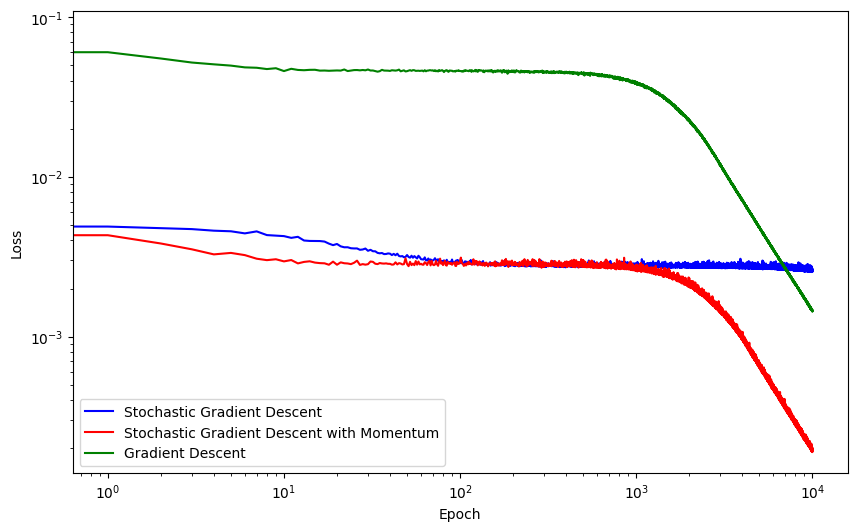

In [52]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,6))
pyplot.plot(SGD, "b-", label="Stochastic Gradient Descent")
pyplot.plot(SGD_Mo, "r-", label="Stochastic Gradient Descent with Momentum")
pyplot.plot(GD, "g-", label="Gradient Descent")
pyplot.loglog()
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend()

### Task 10: Example Evaluation (optional)

We want to see what the network has learned.
Therefore, we evaluate some data points that would represent a typical Swiss student (except for the school entry, where we select one of them randomly).
You can select a specific example, but you can also imagine a student.
Please refer to https://archive.ics.uci.edu/ml/datasets/Student+Performance on possible values and the implementation in Tasks 1 and 2 on how to generate an input sample $\vec x$ for our network. Also, remember that input data need to be standardized before feeding it to the network. 

Compute the scores that your student would likely get by asking the network, using the parameters $\Theta$ optimized with stochastic gradient descent.



In [53]:
Theta3 = copy.deepcopy(Theta)
_, out_theta = gradient_descent(X, T, Theta3, B=16, eta=0.001, mu=0.9)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [54]:
# select a specific example
example = pre_X[:,1].reshape((-1,1))

print(example.reshape(-1))


[ 1.  1. -1. 17.  1. -1.  1.  1.  1.  1.  2.  0. -1.  1. -1. -1. -1.  1.
  1. -1.  5.  3.  3.  1.  1.  3.  2.]


In [55]:
# compute network output
prediction, _ = network(standardize(example, mean, std), out_theta)
print("Prediction :\t", prediction.reshape(-1) * 20)
print("Target :\t", T[:,1] * 20)

Prediction :	 [10.74479624 10.44443151 11.21314408]
Target :	 [ 9. 11. 11.]


### Task 11: Influence of Data Dimensions (optional)


For some dimensions in the input feature $\vec x$, we want to test how different input values for this dimension would influence the outcome.
Particularly, we test:

  * Gender at index $d=2$: change between male ($1$) and female ($-1$)
  * Weekly study time at index $d=10$: vary in the range $[1,4]$ 
  * Past Failures at index $d=11$: vary in range $[0,3]$ 
  * Additional classes at index $d=14$: change between yes ($1$) and no ($-1$)
  * Romantic relations at index $d=19$: change between yes ($1$) and no ($-1$)
  * Weekday alcohol consumption at index $d=23$: varies in the range $[1,6]$.

Note that the indexes include the fact that we are omitting some input dimensions, so they might differ from what is listed on the webpage.

Did you expect this output?



In [56]:
# implement a way to modify the input at a given index with certain values
# and to predict and print the network output for this modification
features2test = {
    'Gender': {'index': 2, 'val': [1,-1]},
    'Weekly study time': {'index': 10, 'val': list(range(1,5))},
    'Past Failures': {'index': 11, 'val': list(range(4))},
    'Additional classes': {'index': 14, 'val': [1,-1]},
    'Romantic relations': {'index': 19, 'val': [1,-1]},
    'Weekday alcohol consumption': {'index': 23, 'val': list(range(1,7))}
}
# 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours
value2label = {'Gender': {1: 'Male', -1: 'Female'},
               'Weekly study time': {1: '< 2 hours', 2: '2 - 5 hours', 3: '5 - 10 hours', 4: '> 10 hours'},
               'Past Failures': {i:f'{i} failure(s)' for i in list(range(4))},
               'Additional classes': {1: 'Y', -1: 'N'},
               'Romantic relations': {1: 'Y', -1: 'N'},
               'Weekday alcohol consumption': {1: 'Very low', 2: 'Low', 3: 'Moderate low', 4:'Moderate high',5: 'High', 6: 'Very high'}
              }



In [57]:
# run this with the 6 modifications and their according to values as seen above
for k, v in features2test.items():
    print(f'For {k}:')
    for value in v['val']:
        c_example = example.copy()
        c_example.reshape(-1)[v['index']] = value
        prediction, _ = network(standardize(c_example, mean, std), out_theta)
        print(f'Value: \t{value2label[k][value]}')
        print("Prediction :\t", prediction.reshape(-1) * 20)
        print('--')
    print('==========================================================')


For Gender:
Value: 	Male
Prediction :	 [10.06173278  9.57375557  9.99655483]
--
Value: 	Female
Prediction :	 [10.74479624 10.44443151 11.21314408]
--
For Weekly study time:
Value: 	< 2 hours
Prediction :	 [10.39132206 10.36000784 11.03985909]
--
Value: 	2 - 5 hours
Prediction :	 [10.74479624 10.44443151 11.21314408]
--
Value: 	5 - 10 hours
Prediction :	 [11.75146784 11.04217907 11.89436476]
--
Value: 	> 10 hours
Prediction :	 [13.07375343 11.81906157 12.71152541]
--
For Past Failures:
Value: 	0 failure(s)
Prediction :	 [10.74479624 10.44443151 11.21314408]
--
Value: 	1 failure(s)
Prediction :	 [7.42611912 7.55442036 8.34106542]
--
Value: 	2 failure(s)
Prediction :	 [5.59944134 6.43652296 7.33283149]
--
Value: 	3 failure(s)
Prediction :	 [5.39892863 7.31855533 8.36341602]
--
For Additional classes:
Value: 	Y
Prediction :	 [ 9.82843737  9.60077039 11.35423819]
--
Value: 	N
Prediction :	 [10.74479624 10.44443151 11.21314408]
--
For Romantic relations:
Value: 	Y
Prediction :	 [10.78498439 